# Introduction to Data Science
## Unsupervised methods
***

Spring 2017 - Prof. Foster Provost

Teacher Assistant: Maria L Zamora Maass

In [ ]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
import pickle
from scipy import sparse
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 17,12

np.random.seed(36)

### Data Cleaning 
As usual, we will start by reading in some data. Today we will be looking at movie rating data that was derived from Tweets (https://github.com/sidooms/MovieTweetings). The data set consists of three files: `movies.dat`, `ratings.dat`, and `users.dat`. 

It was created to help research on 'ratings used by recommender systems' http://crowdrec2013.noahlab.com.hk/papers/crowdrec2013_Dooms.pdf

We will only be looking at the first two files. Both of them are located in the `data` directory. The _novies_ file includes information per movie (one row per movie), and the _ratings_ file includes one or more ratings per movie. Both files have the columns **movie_id**.

These files **do not** have a header row at the top so we will manually set it.

In [2]:

### Read in the movies data
#movies = pd.read_csv("data/movies.dat", names=['movie_id', 'movie_title', 'genre'], 
#                      encoding='utf-8', sep="\:\:", engine='python')

### Movie ids don't start at 0 and some are missing, let's remap
#movie_id_map = dict(zip(np.argsort(movies['movie_id'].unique())*-1, movies['movie_id'].unique()))

### Given the mapping, let's replace the values
#movies = movies.replace({"movie_id": {v: k for k, v in movie_id_map.items()}})
#movies['movie_id'] = movies['movie_id'] * -1

#movies.tail()

In [5]:

### Read in the ratings data
#ratings = pd.read_csv("data/ratings.dat", names=['user_id', 'movie_id', 'rating', 'rating_timestamp'], 
#                      sep="\:\:", engine='python')

### User ids start at 1, let's bump them all down by 1
#ratings['user_id'] = ratings['user_id'] - 1

### Make movie ids match the ones from our movie's data
#ratings = ratings.replace({"movie_id": {v: k for k, v in movie_id_map.items()}})
#ratings['movie_id'] = ratings['movie_id'] * -1

### Put our mapping back in order
#movie_id_map = dict((key*-1, value) for (key, value) in movie_id_map.items())


In [6]:
#ratings.head()

Now that we have our two data files loaded in and cleaned, we can create one data frame that **joins** both of them together. 

Function:  ** _merge(left,right, how='inner', on=None,...)_ **

This 'how' parameter is similar to SQL [details here](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html)

- left: use only keys from left frame (SQL: left outer join)
- right: use only keys from right frame (SQL: right outer join)
- outer: use union of keys from both frames (SQL: full outer join)
- inner: use intersection of keys from both frames (SQL: inner join) - default


In [7]:

#movies_ratings = pd.merge(movies, ratings, on="movie_id").drop(['genre', 'rating_timestamp'], axis=1)


In [8]:

#movies_ratings.tail()


Now, we have only one dataframe with titles and more than one rating per movie. Let's see one of the records.

In [9]:

#movies_ratings [ movies_ratings.movie_id == 22725 ]


Since there are **many users rating many movies**, this data can be represented as a movie-by-user matrix (kind of like the document-by-word matrices we saw in our text class). In this new matrix, we can let movies be the rows, users are the columns, and each cell is filled in with a rating.

We'll do this with the "scipy" library and the sparse module.

In [11]:

#data = sparse.csr_matrix((movies_ratings['rating'], (movies_ratings['movie_id'], movies_ratings['user_id'])), 
#                         shape=(max(movies_ratings['movie_id'])+1, max(movies_ratings['user_id'])+1))

#### Format: rating in pairs of (movie, user) 

#data


This will not fit in EC2, so I'm going to dump this to a **pickle** object and let you read it in.

What is a pickle?? https://docs.python.org/2/library/pickle.html

" The data format used by pickle is Python-specific. This has the advantage that there are no restrictions imposed by external standards such as JSON or XDR (which can’t represent pointer sharing); however it means that non-Python programs may not be able to reconstruct pickled Python objects. By default, the pickle data format uses a relatively compact binary representation. If you need optimal size characteristics, you can efficiently compress pickled data. "

In [12]:

#with open('data/movies_ratings.pickle', 'wb') as f:
#    pickle.dump(data, f)
#    f.close()

#with open('data/movies_clean.pickle', 'wb') as f:
#    pickle.dump(movies, f)
#    f.close()
    

### Reading data from pickle (EC2)

Let's read the cleaned data!

In [25]:

with open('data/movies_ratings.pickle', 'rb') as f:
    data = pickle.load(f,encoding='latin1')
    f.close()

with open('data/movies_clean.pickle', 'rb') as f:
    movies = pickle.load(f,encoding='latin1')
    f.close()
    
print ("DATA REPRESENTATION: ", data)
print ("\n (Movie,User) Rating \n")
print (data[0:5])
print ("\n Movies information \n")
print (movies.head())



DATA REPRESENTATION:    (0, 20903)	5
  (1, 35627)	10
  (2, 28455)	10
  (3, 7207)	6
  (4, 7396)	8
  (4, 10813)	7
  (4, 12501)	8
  (4, 12658)	9
  (4, 12889)	10
  (4, 14769)	7
  (4, 18924)	10
  (4, 20903)	7
  (4, 22828)	7
  (4, 29264)	10
  (4, 33417)	9
  (4, 37083)	6
  (5, 7396)	7
  (5, 12501)	7
  (5, 14769)	5
  (6, 12069)	5
  (6, 28529)	4
  (7, 28529)	3
  (8, 12362)	7
  (9, 28529)	4
  (10, 16786)	4
  :	:
  (22735, 14540)	7
  (22735, 14731)	1
  (22735, 14945)	9
  (22735, 15141)	7
  (22735, 18375)	10
  (22735, 21534)	10
  (22735, 23331)	10
  (22735, 24268)	1
  (22735, 24623)	8
  (22735, 25944)	6
  (22735, 27905)	5
  (22735, 28353)	10
  (22735, 29048)	8
  (22735, 29861)	7
  (22735, 33795)	10
  (22735, 36416)	7
  (22735, 38026)	7
  (22735, 39459)	10
  (22736, 282)	9
  (22737, 3779)	8
  (22738, 26559)	5
  (22739, 17145)	8
  (22740, 3779)	4
  (22741, 24653)	6
  (22742, 17962)	9

 (Movie,User) Rating 

  (0, 20903)	5
  (1, 35627)	10
  (2, 28455)	10
  (3, 7207)	6
  (4, 7396)	8
  (4, 10813)	7
  (

### Dimensionality reduction

This matrices have many dimensions. How can we predict _likeliness of a movie_ by a particular customer using this data?  How can we find 'similar' movies? 

We would like to have a low-dimensional representation of the original customer-product space and then compute
neighborhood in the reduced space. If, for example, we wanted to see/plot this data into a 2 dimensional space, we would have to find some way of reducing are large number of dimensions (**a.k.a. Matrix decompositions). 

One way of doing this is with **SVD = Singular Value Decomposition**.

[More info here](http://scikit-learn.org/stable/modules/decomposition.html#lsa)

This decomposition is basically a factorization of 1 matrix into 3 matrices that provides the best lower rank approximation. One of those matrices is the "diagonal" with non-negative real numbers, it has the singular values (ordered) so that the upper left diagonal element of contains the largest singular value. 

SVD applications:

- To compute a pseudoinverse (e.g. to solve linear least squares problems).
- Use for principal component analysis 
- Signal processing and pattern recognition
- Dimensionality Reduction for recommendation systems 
- .. and more

In [14]:
# D dimensional space

D = 2

svd = TruncatedSVD(D)
svd.fit(data)

svd


TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

In [15]:

components = svd.transform(data)
components


array([[ 0.07641767,  0.155738  ],
       [ 0.0305449 ,  0.07465089],
       [ 0.0519458 ,  0.18200173],
       ..., 
       [ 0.04122396,  0.05988409],
       [ 0.05055729,  0.06640267],
       [ 0.19962424,  0.14346038]])

With our data reduced to 2 components, we can visualize it easily. Each of this rows is a (x,y) point.

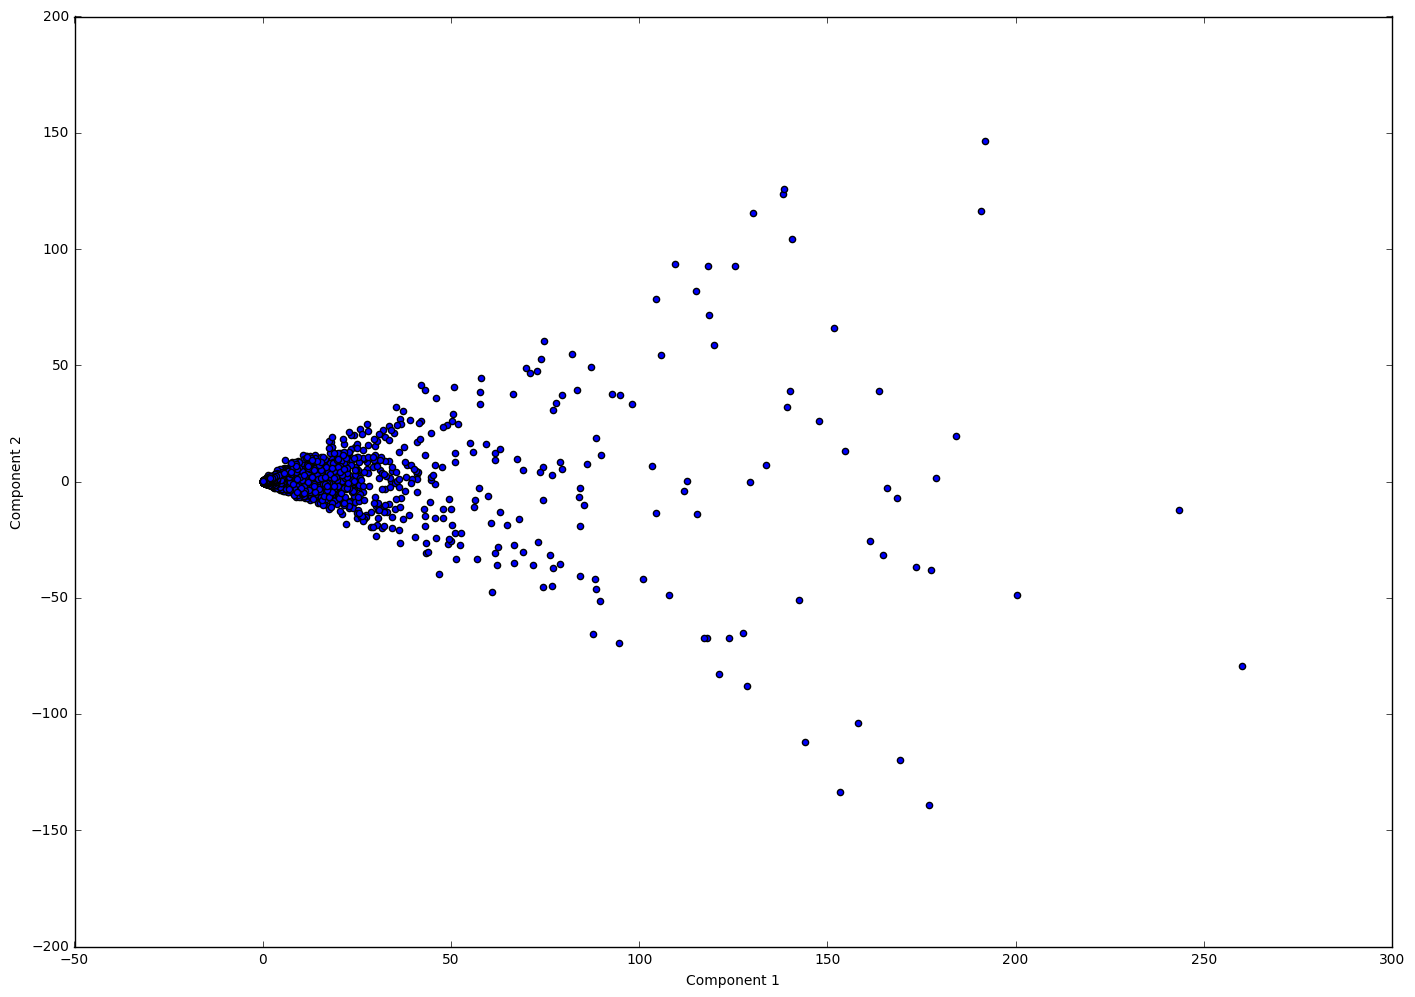

In [16]:

plt.scatter(components[:,0], components[:,1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


Very messy... We can write a few small functions to pick out a few of our favorite movies and see what's around them!

In [17]:

def movie_search(movie_name_input):
    condition = movies.movie_title.str.contains(movie_name_input) 
    return movies[ condition ]


In [18]:

movie_search("The Matrix")


,movie_id,movie_title,genre
7613,7613,The Matrix (1999),Action|Adventure|Sci-Fi
8589,8589,The Matrix Reloaded (2003),Action|Sci-Fi
8668,8668,The Matrix Revolutions (2003),Action|Adventure|Sci-Fi


In [19]:

movie_search("Furious")


,movie_id,movie_title,genre
1363,1363,The Fast and the Furious (1955),Crime|Drama|Mystery|Thriller
8574,8574,The Fast and the Furious (2001),Action|Crime|Thriller
9623,9623,2 Fast 2 Furious (2003),Action|Crime|Thriller
11440,11440,The Fast and the Furious: Tokyo Drift (2006),Action|Crime|Drama|Thriller
12884,12884,Fast & Furious (2009),Action|Crime|Drama|Thriller
16521,16521,Furious Love (2010),Documentary
17075,17075,Fast & Furious 6 (2013),Action|Crime|Thriller
20391,20391,Furious 7 (2015),Action|Crime|Thriller


In [22]:

def movie_plotter(movie_id, components, x_buffer=3, y_buffer=3):
    
    # movie_id is the index, we want the 2 components
    
    x = components[movie_id][0]
    y = components[movie_id][1]
    
    # And we want all of the other movies with close values (range: less and greater)

    xs = [x - x_buffer, x + x_buffer]
    ys = [y - y_buffer, y + y_buffer]

    # Let's plot all the points and then only look at the zoom in that range (xs, ys)
    plt.scatter(components[:,0], components[:,1])
    plt.title('MOVIES WITH CLOSE COMPONENTS TO: '+ movies['movie_title'].loc[movie_id] +"\n", fontsize=14)
    
    plt.xlim(xs)
    plt.ylim(ys)

    # Include titles of movies in that range
    
    import re
    for x, y, title in zip(components[:,0], components[:,1], movies['movie_title']):
        if x >= xs[0] and x <= xs[1] and y >= ys[0] and y <= ys[1]:
            title_without_symbols = re.sub(r'[^\w]', ' ', title)
            plt.text(x, y, title_without_symbols)
            

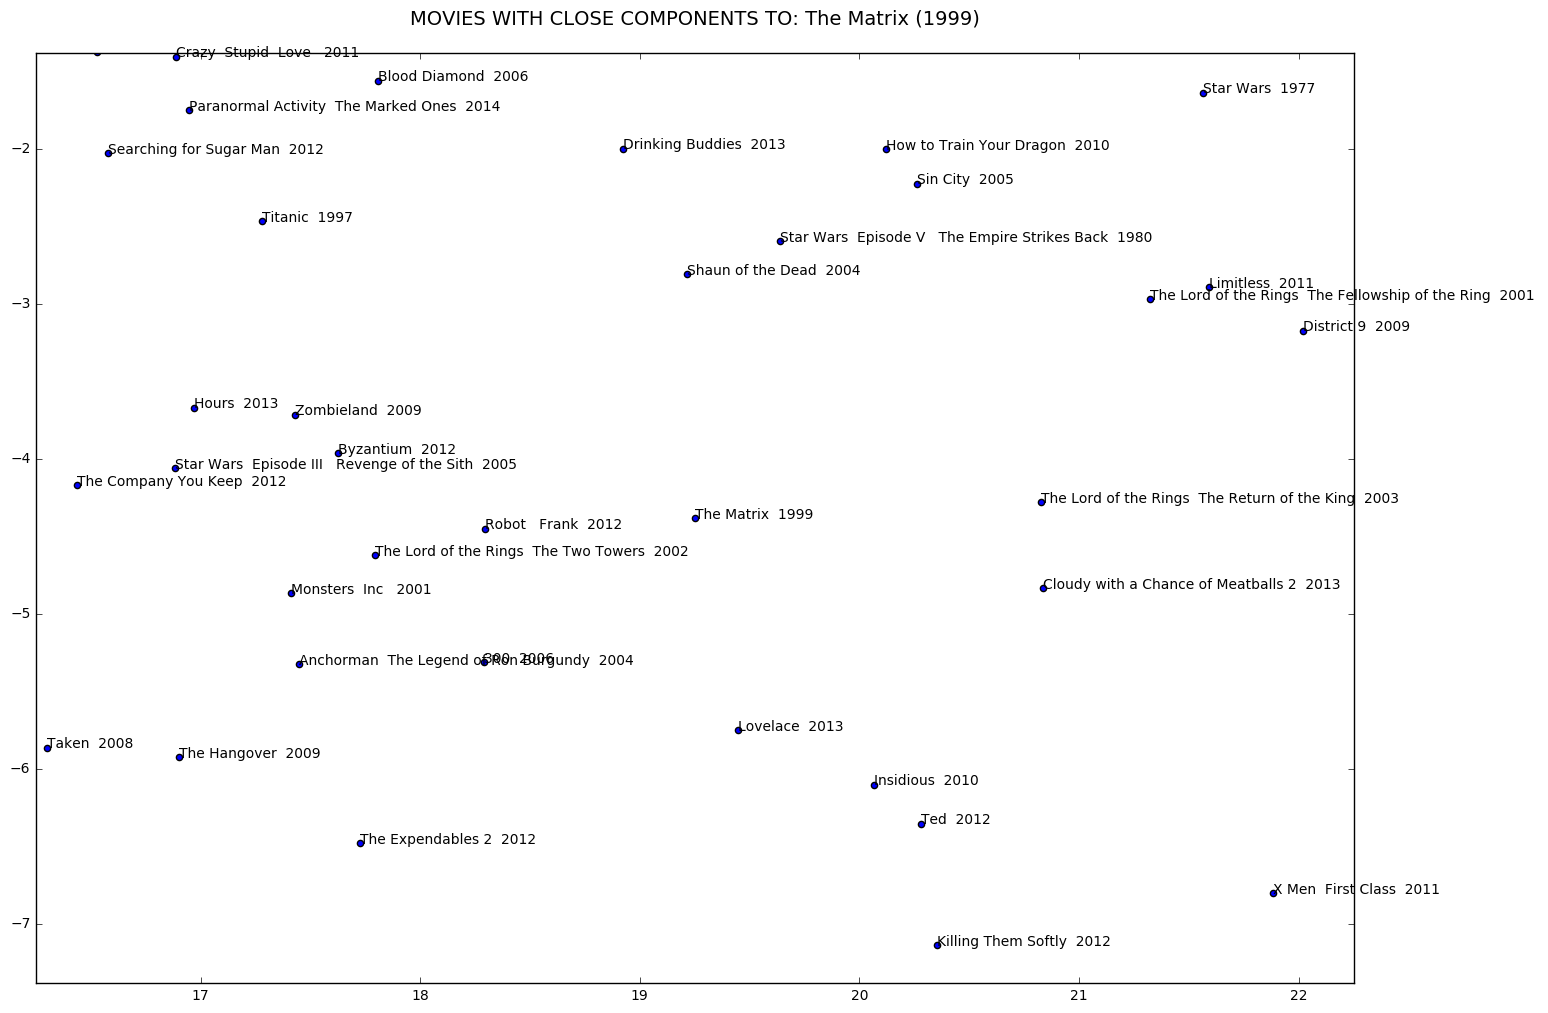

In [23]:

id_to_plot_similar = 7613

movie_plotter( id_to_plot_similar, components )


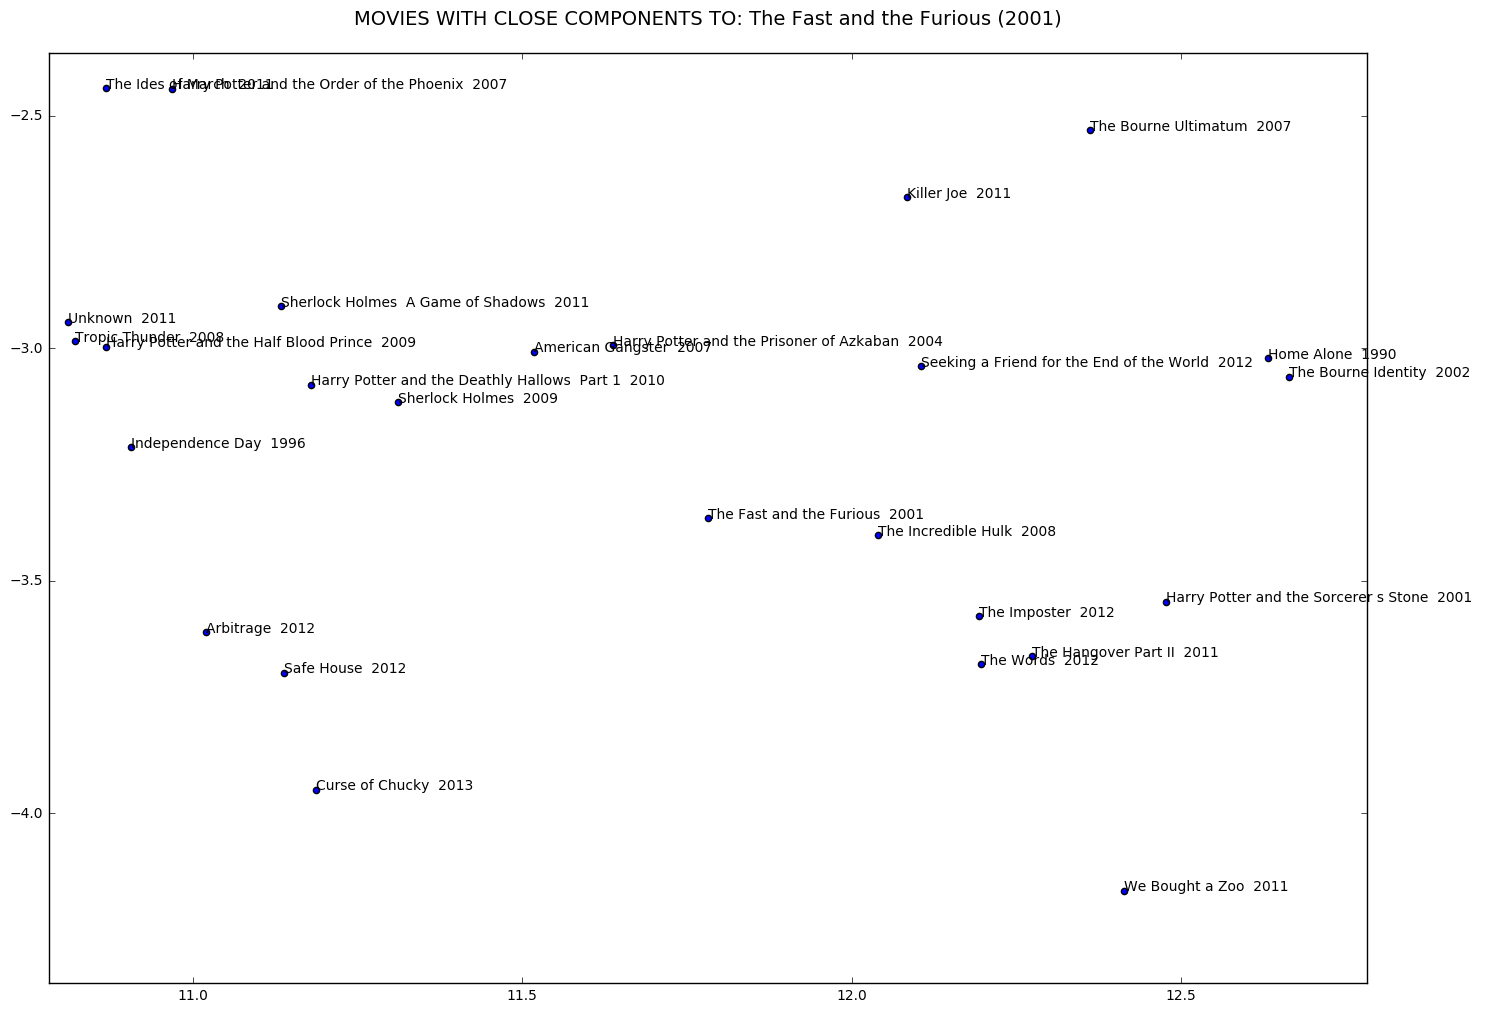

In [24]:

id_to_plot_similar = 8574

movie_plotter( id_to_plot_similar, components, 1,1 )
